In [1]:
# !jt -t monokai -ofs 10 -dfs 8 -cellw 90%

In [104]:
import os
import sys
import numpy as np
import pandas as pd
import json
import re
import pathlib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [105]:
complexes = []
dir = "/media/hdd1/roproQ3drew"
dirs = os.listdir(dir)
for dr in dirs:
    if os.path.isdir(dir+'/'+dr):
        if re.search(r'\b\w{4}\b', dr):
            data = dir+'/'+dr+'/'+dr+"_TOTAL.json"
            if os.path.exists(data):
                complexes.append(dr)
print("we have Processed %d datasets"%len(complexes))                

we have Processed 138 datasets


In [106]:
df_total = pd.DataFrame()
for cmplx in complexes:
    df = pd.read_json(dir+'/'+cmplx+'/'+cmplx+'_TOTAL.json')
    df = df[df.complex != 1]    
    df = df[df.complex != 0]
    df = df[df.ProQ3D > 0.0]
    df.reset_index(drop=True, inplace=True)
    df.drop(['structure','method', 'name','H1_cluster', 'complex',
           'H1_distance', 'H1_sequence', 'H2_cluster', 'H2_distance', 'nres_all', 'ref',
           'H2_sequence', 'H3_cluster', 'H3_distance', 'H3_sequence', 'L1_cluster',
           'L1_distance', 'L1_sequence', 'L2_cluster', 'L2_distance',
           'L2_sequence', 'L3_cluster', 'L3_distance', 'L3_sequence'], axis=1, inplace=True)
    mm = MinMaxScaler()
    df_scaled = pd.DataFrame(mm.fit_transform(df),columns = df.columns)
    df_scaled.columns = [str(col) + '_scaled' for col in df.columns]
    df_scaled.drop(['rmsd_scaled'], axis=1, inplace=True)
    df.loc[df.rmsd <= 2.0, 'docked'] = True
    df.loc[df.rmsd > 2.0, 'docked'] = False
    df = df.join(df_scaled)
    df_total = df_total.append(df, ignore_index=True)
    df_total.dropna(inplace=True)    

In [107]:
df_docked = df_total.loc[df_total.rmsd <=2.0]
df_total.drop(['rmsd'], axis=1, inplace=True)
df_total.docked = df_total.docked.astype(int)

In [108]:
df_total.columns

Index(['zrank', 'ProQ2D', 'ProQRosCenD', 'ProQRosFAD', 'ProQ3D',
       'complex_normalized', 'dG_separated', 'dG_separated/dSASAx100',
       'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'delta_unsatHbonds',
       'hbond_E_fraction', 'hbonds_int', 'nres_int', 'per_residue_energy_int',
       'sc_value', 'side1_normalized', 'side1_score', 'side2_normalized',
       'side2_score', 'fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec', 'pro_close',
       'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13',
       'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity', 'rama_prepro',
       'total_score', 'docked', 'zrank_scaled', 'ProQ2D_scaled',
       'ProQRosCenD_scaled', 'ProQRosFAD_scaled', 'ProQ3D_scaled',
       'complex_normalized_scaled', 'dG_separated_scaled',
       'dG_separated/dSASAx100_scaled', 'dSASA_hphobic_scaled',
       'dSASA_int_scaled', 'dSASA_polar_scaled', 'delta_unsatHbonds_scaled',
       'hbond_E_fractio

In [109]:
df_total.docked.value_counts()

0    11983
1     1089
Name: docked, dtype: int64

In [116]:
corr_matrix = df_total.corr()
corr_matrix['docked'].sort_values(ascending=True)

dG_separated_scaled             -0.414651
dG_separated                    -0.413695
dG_separated/dSASAx100          -0.385432
dG_separated/dSASAx100_scaled   -0.347020
side1_score_scaled              -0.282437
                                   ...   
dSASA_hphobic_scaled             0.251086
dSASA_int_scaled                 0.251995
hbonds_int_scaled                0.355466
hbonds_int                       0.393392
docked                           1.000000
Name: docked, Length: 81, dtype: float64

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_total, df_total['docked']):
    strat_train_set = df_total.loc[train_index]
    strat_test_set = df_total.loc[test_index]

In [119]:
print(strat_train_set.docked.value_counts()/ len(strat_train_set))
print(strat_test_set.docked.value_counts()/ len(strat_test_set))

0    0.916707
1    0.083293
Name: docked, dtype: float64
0    0.916635
1    0.083365
Name: docked, dtype: float64


In [12]:
X_train_prep = strat_train_set.drop("docked", axis=1)
y_train = strat_train_set["docked"].copy()
X_test_prep = strat_test_set.drop("docked", axis=1)
y_test = strat_test_set["docked"].copy()

In [13]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train_prep)
X_test = ss.fit_transform(X_test_prep)
y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)

In [14]:
from sklearn import svm

In [15]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(X_train, y_train_1)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(clf, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.97478177, 0.96896217, 0.96508244, 0.97187197, 0.97187197,
       0.97478177, 0.96407767, 0.97184466, 0.97572816, 0.98058252])

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
cross_val_score(sgd_clf, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.95441319, 0.96023278, 0.95150339, 0.95150339, 0.94956353,
       0.96023278, 0.92912621, 0.96116505, 0.95436893, 0.94563107])

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train_1, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

array([[9354,   90],
       [ 206,  656]])

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)

0.8793565683646113

In [23]:
recall_score(y_train_1, y_train_pred)

0.7610208816705336

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3,
                             method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

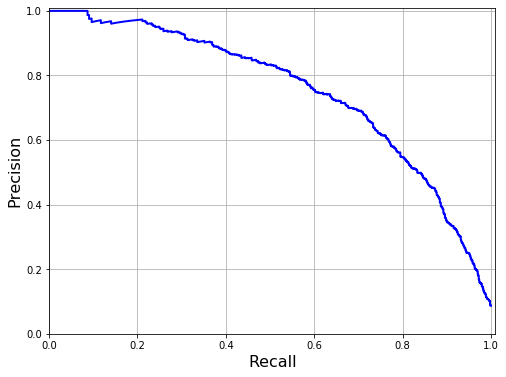

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.01, 0, 1.01])
    plt.grid(True)

plt.figure(figsize=(8, 6), facecolor="white")
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)

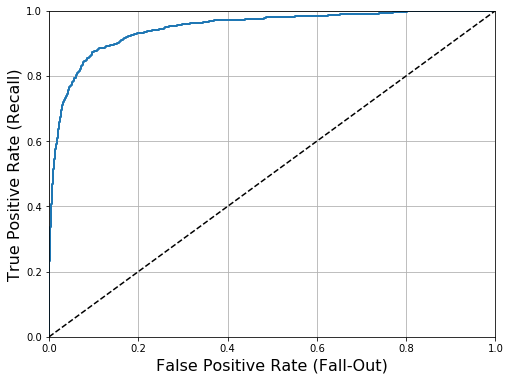

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6), facecolor="white")               # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_1, y_scores)

0.947013461203961

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")

In [31]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1, y_scores_forest)

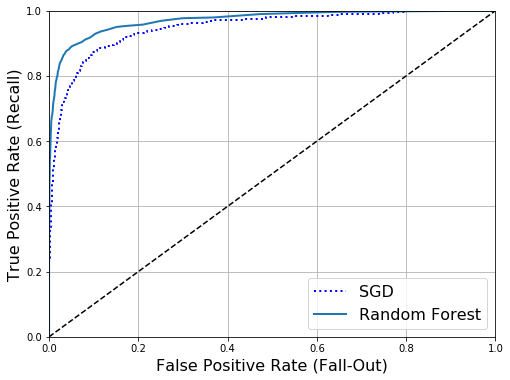

In [32]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [33]:
roc_auc_score(y_train_1, y_scores_forest)

0.9714231331645032

In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

/home/drewaight/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [35]:
xgb_clf = XGBClassifier(objective= 'binary:logistic', nthread=16, seed=42)
xgb_clf.fit(X_train, y_train_1)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [36]:
# parameters = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

In [37]:
parameters = {'nthread':[16], #when use hyperthread, xgboost may become slower
                        'objective':['binary:logistic'],
                        'learning_rate': [0.3, 0.1, 0.05], #so called `eta` value
                        'max_depth': [5, 9, 7],
                        'n_estimators': [220, 440, 660],
                        'min_child_weight': [1, 4],
                        'silent': [1],
                        'subsample': [0.7, 1],
                        'colsample_bytree': [0.7, 1]}

In [38]:
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 16,
    cv = 10,
    verbose=True
)

In [39]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  7.7min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed: 19.1min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed: 39.2min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed: 67.2min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed: 102.1min
[Parallel(n_jobs=16)]: Done 2160 out of 2160 | elapsed: 134.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     verbosity=None),
             iid='deprecated', n_jobs=16,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.3, 0.1, 0.05],
                         'max_depth': [5, 9, 7], 'min_child_weight': [1

In [40]:
 final_xgb = grid_search.best_estimator_

In [41]:
import pickle
#save
pickle.dump(final_xgb, open("final_xgb.dat", "wb"))

In [42]:
# load
final_xgb_loaded = pickle.load(open("final_xgb.dat", "rb"))

In [43]:
print(final_xgb_loaded)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
              subsample=0.7, tree_method=None, validate_parameters=False,
              verbosity=None)


In [44]:
cross_val_score(final_xgb_loaded, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.97381183, 0.97478177, 0.97187197, 0.9757517 , 0.97381183,
       0.98060136, 0.97087379, 0.97087379, 0.97281553, 0.98737864])

In [45]:
final_xgb_loaded.feature_names = list(X_train_prep.columns)
final_xgb_loaded.get_booster().feature_names = final_xgb_loaded.feature_names

In [46]:
from collections import OrderedDict
fnum = 15
booster = final_xgb_loaded.get_booster()
gain = booster.get_score(importance_type="gain")
gain_top = pd.DataFrame([OrderedDict(sorted(gain.items(), key=lambda x: x[1], reverse=True)[:fnum])])
weight = booster.get_score(importance_type="weight")
weight_top = pd.DataFrame([OrderedDict(sorted(weight.items(), key=lambda x: x[1], reverse=True)[:fnum])])
cover = booster.get_score(importance_type="cover")
cover_top = pd.DataFrame([OrderedDict(sorted(cover.items(), key=lambda x: x[1], reverse=True)[:fnum])])

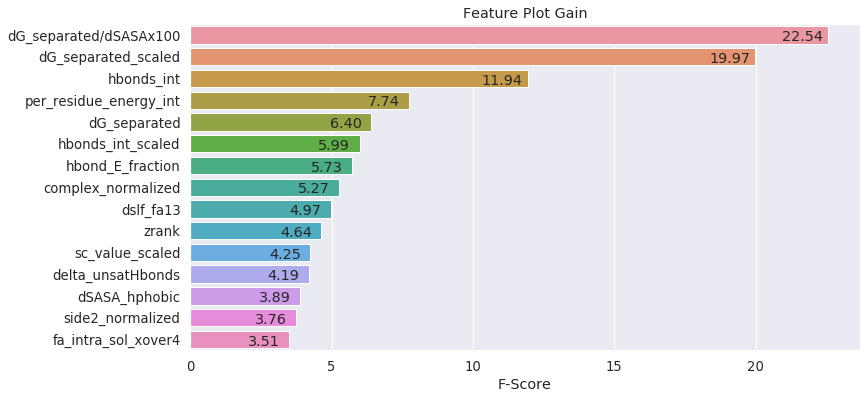

In [47]:
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Gain')
sns.barplot(data=gain_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -0.9  ,
            p.get_y()+p.get_height()/2. + 0.28,
            '{:1.2f}'.format(width),
            ha="center")

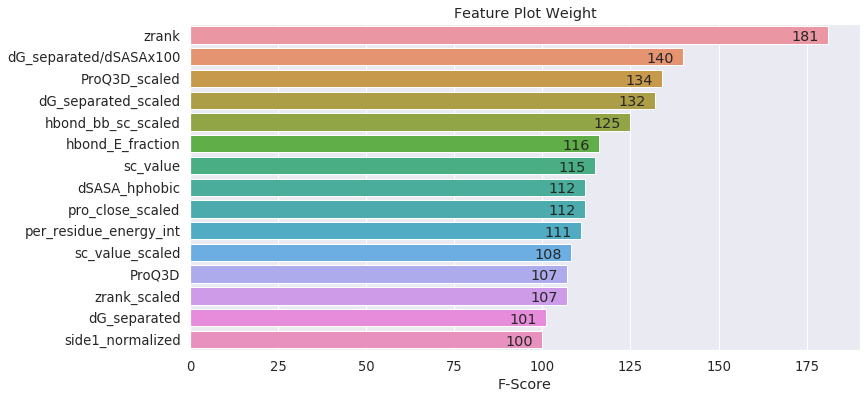

In [48]:
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Weight')
sns.barplot(data=weight_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -6.5  ,
            p.get_y()+p.get_height()/2. + 0.28,
            '{:1.0f}'.format(width),
            ha="center")

In [49]:
# from xgboost import plot_importance
# plt.rcParams["figure.figsize"] = [14,8]
# plt.rcParams['figure.facecolor'] = 'white'
# final_xgb_loaded.get_booster().feature_names = final_xgb_loaded.feature_names
# plot_importance(final_xgb_loaded.get_booster(),
#                 max_num_features=15, title='Feature importance Weight', 
#                 grid=False)
# plt.show()

In [50]:
# cvres = grid_search.cv_results_
# # for key, value in grid_search.cv_results_.items() :
# #     print (key)

# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

In [51]:
y_probas_xgb = cross_val_predict(final_xgb_loaded, X_train, y_train_1, cv=3,
                                 method="predict_proba")

In [52]:
y_scores_xgb = y_probas_xgb[:, 1] # score = proba of positive class
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train_1, y_scores_xgb)

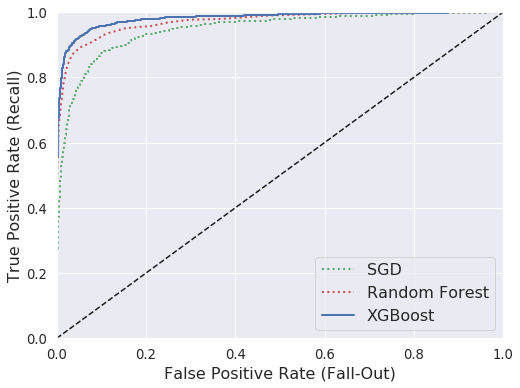

In [53]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr, tpr, "g:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, "r:", linewidth=2, label="Random Forest")
plot_roc_curve(fpr_xgb, tpr_xgb, "XGBoost")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [54]:
train_roc = roc_auc_score(y_train_1, y_scores_xgb)

In [55]:
y_probas_xgb_test = cross_val_predict(final_xgb_loaded, X_test, y_test, cv=3,
                                     method="predict_proba")

In [56]:
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores_xgb)

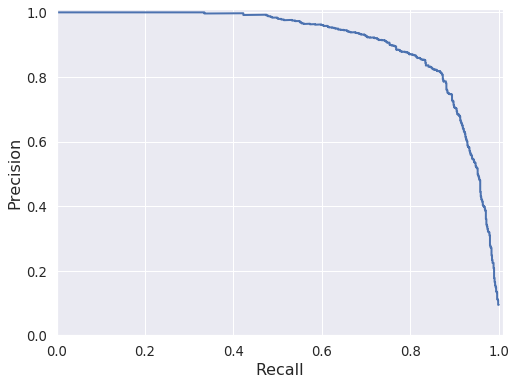

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.01, 0, 1.01])
    plt.grid(True)

plt.figure(figsize=(8, 6), facecolor="white")
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [58]:
y_scores_xgb_test = y_probas_xgb_test[:, 1] # score = proba of positive class
fpr_xgb_t, tpr_xgb_t, thresholds_xgb_t = roc_curve(y_test, y_scores_xgb_test)

In [59]:
test_roc = roc_auc_score(y_test, y_scores_xgb_test)

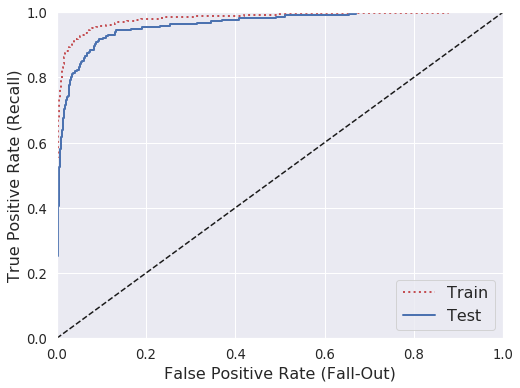

In [60]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr_xgb, tpr_xgb, "r:", linewidth=2, label="Train")
plot_roc_curve(fpr_xgb_t, tpr_xgb_t, "Test")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

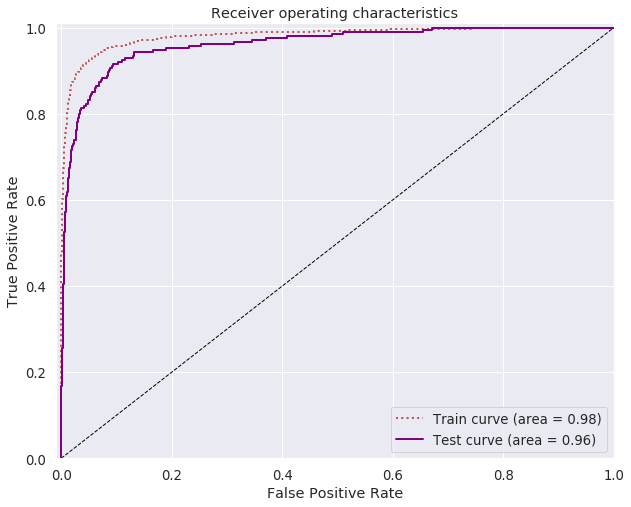

In [61]:
plt.figure(figsize=(10, 8), facecolor="white")
lw = 2
plt.grid(True)
plt.plot(fpr_xgb, tpr_xgb, "r:",
         lw=lw, label='Train curve (area = %0.2f)' % train_roc)
plt.plot(fpr_xgb_t, tpr_xgb_t, color="Purple",
         lw=lw, label='Test curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 16})
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix
y_pred =(y_scores_xgb_test>0.6)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2336   26]
 [  82  133]]


In [63]:
df_docked.drop(['docked'], axis=1, inplace=True)
df_docked.describe()

/home/drewaight/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,zrank,ProQ2D,ProQRosCenD,ProQRosFAD,ProQ3D,rmsd,complex_normalized,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,...,hbond_lr_bb_scaled,hbond_bb_sc_scaled,hbond_sc_scaled,dslf_fa13_scaled,omega_scaled,fa_dun_scaled,p_aa_pp_scaled,yhh_planarity_scaled,rama_prepro_scaled,total_score_scaled
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,-71.332526,0.452102,0.491237,0.942645,0.661919,0.965282,-3.643566,-53.588933,-3.308371,866.165736,...,0.394300,0.416855,0.381443,0.348072,0.455693,0.470987,0.470241,0.447385,0.470493,0.212864
std,13.147780,0.098352,0.134195,0.031233,0.086502,0.448816,0.207480,13.606266,0.648394,174.447587,...,0.203746,0.212695,0.204646,0.237093,0.211077,0.192410,0.201787,0.218262,0.219786,0.182244
min,-128.723010,0.261495,0.207538,0.809706,0.427100,0.177613,-4.015417,-99.511589,-4.836942,401.621063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-78.336100,0.369752,0.392656,0.927897,0.601478,0.610355,-3.814606,-61.835026,-3.708296,763.726685,...,0.244442,0.259641,0.238151,0.141790,0.303962,0.345690,0.335134,0.285067,0.317456,0.070344
50%,-69.348900,0.454078,0.490594,0.949408,0.675499,0.866282,-3.647868,-52.386150,-3.352988,840.955200,...,0.375112,0.398675,0.365059,0.321073,0.445703,0.467762,0.473540,0.432435,0.464252,0.162127
75%,-61.840100,0.530508,0.615592,0.965539,0.734428,1.257839,-3.505647,-45.695885,-2.975060,947.971802,...,0.527453,0.560982,0.519145,0.511266,0.593853,0.599357,0.605843,0.591057,0.622601,0.319971
max,-45.754400,0.668251,0.730895,0.993105,0.835526,1.997224,-2.573890,1.593220,0.096879,1603.673340,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
df_docked_small = df_docked[['rmsd', 'dG_separated_scaled', 'side1_score_scaled',
                           'dG_separated/dSASAx100_scaled', 'hbonds_int_scaled']]

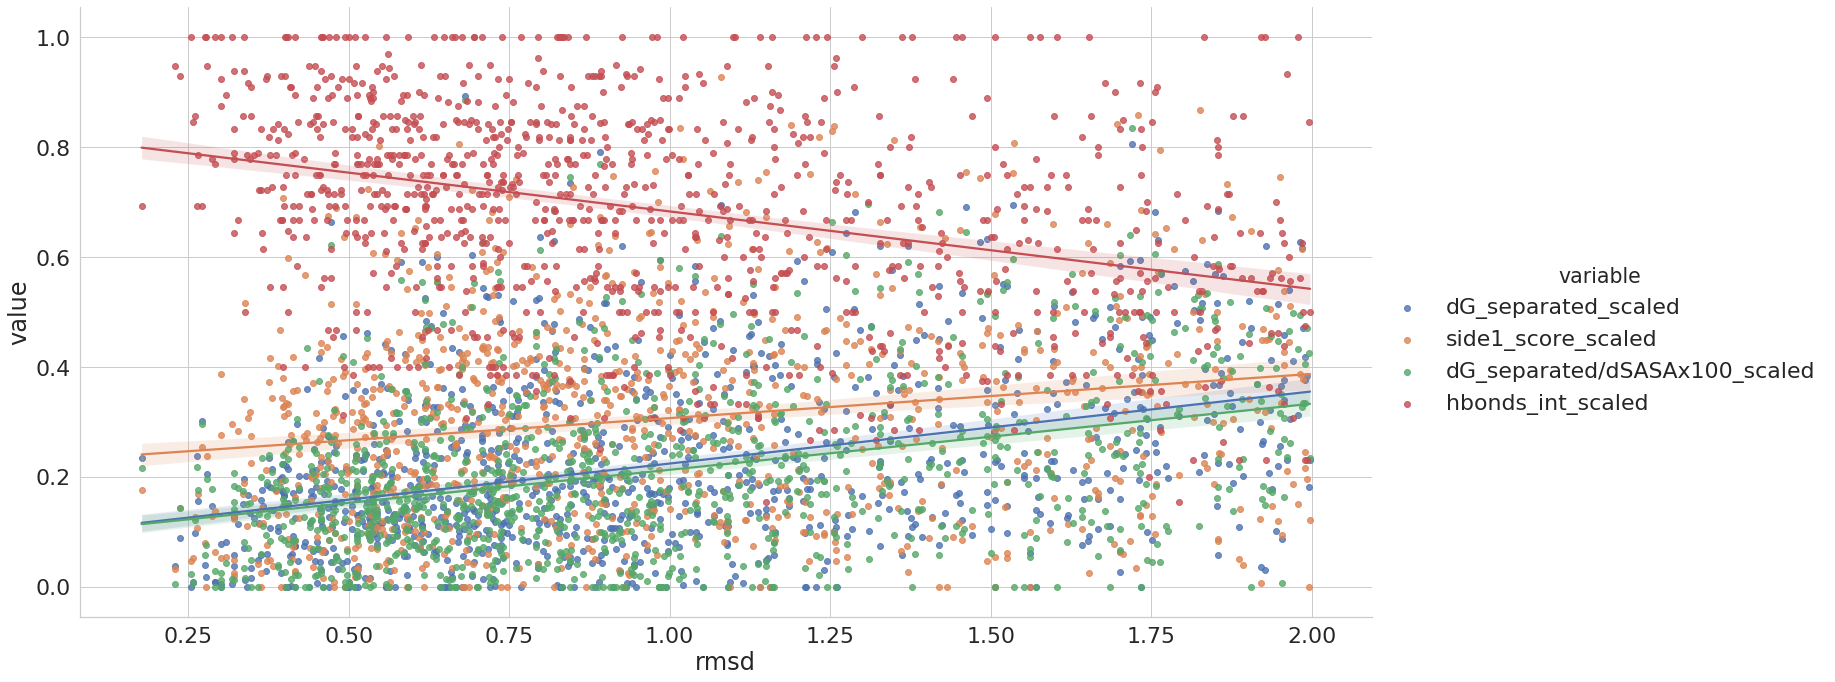

In [65]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.lmplot('rmsd', 'value', hue='variable', sharey=False,
           fit_reg=True, height=10, aspect=2, 
           data=pd.melt(df_docked_small, ['rmsd']))


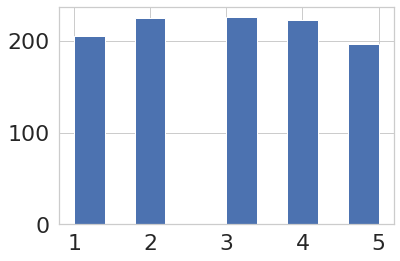

In [66]:
df_docked = df_docked.copy()
df_docked.reset_index(drop=True, inplace=True)
df_docked['rmsd_cat'] = pd.cut(df_docked['rmsd'], bins = [0.0, 0.55, 0.75, 1.0, 1.45, np.inf], labels=[1, 2, 3, 4, 5])
df_docked['rmsd_cat'].hist()
df_docked.dropna(inplace=True)

In [67]:
df_docked.describe()

,zrank,ProQ2D,ProQRosCenD,ProQRosFAD,ProQ3D,rmsd,complex_normalized,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,...,hbond_lr_bb_scaled,hbond_bb_sc_scaled,hbond_sc_scaled,dslf_fa13_scaled,omega_scaled,fa_dun_scaled,p_aa_pp_scaled,yhh_planarity_scaled,rama_prepro_scaled,total_score_scaled
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,-71.332526,0.452102,0.491237,0.942645,0.661919,0.965282,-3.643566,-53.588933,-3.308371,866.165736,...,0.394300,0.416855,0.381443,0.348072,0.455693,0.470987,0.470241,0.447385,0.470493,0.212864
std,13.147780,0.098352,0.134195,0.031233,0.086502,0.448816,0.207480,13.606266,0.648394,174.447587,...,0.203746,0.212695,0.204646,0.237093,0.211077,0.192410,0.201787,0.218262,0.219786,0.182244
min,-128.723010,0.261495,0.207538,0.809706,0.427100,0.177613,-4.015417,-99.511589,-4.836942,401.621063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-78.336100,0.369752,0.392656,0.927897,0.601478,0.610355,-3.814606,-61.835026,-3.708296,763.726685,...,0.244442,0.259641,0.238151,0.141790,0.303962,0.345690,0.335134,0.285067,0.317456,0.070344
50%,-69.348900,0.454078,0.490594,0.949408,0.675499,0.866282,-3.647868,-52.386150,-3.352988,840.955200,...,0.375112,0.398675,0.365059,0.321073,0.445703,0.467762,0.473540,0.432435,0.464252,0.162127
75%,-61.840100,0.530508,0.615592,0.965539,0.734428,1.257839,-3.505647,-45.695885,-2.975060,947.971802,...,0.527453,0.560982,0.519145,0.511266,0.593853,0.599357,0.605843,0.591057,0.622601,0.319971
max,-45.754400,0.668251,0.730895,0.993105,0.835526,1.997224,-2.573890,1.593220,0.096879,1603.673340,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split2.split(df_docked, df_docked['rmsd_cat']):
    strat_train_set_d = df_docked.loc[train_index]
    strat_test_set_d = df_docked.loc[test_index]

In [69]:
print(strat_train_set_d.rmsd_cat.value_counts()/ len(strat_train_set_d))
print(strat_test_set_d.rmsd_cat.value_counts()/ len(strat_test_set_d))

3    0.210221
2    0.209059
4    0.206736
1    0.191638
5    0.182346
Name: rmsd_cat, dtype: float64
4    0.208333
3    0.208333
2    0.208333
1    0.189815
5    0.185185
Name: rmsd_cat, dtype: float64


In [70]:
for set_ in (strat_train_set_d, strat_test_set_d):
    set_.drop('rmsd_cat', axis=1, inplace=True)

In [71]:
X_train_prep_d = strat_train_set_d.drop("rmsd", axis=1)
y_train_d = strat_train_set_d["rmsd"].copy()
X_test_prep_d = strat_test_set_d.drop("rmsd", axis=1)
y_test_d = strat_test_set_d["rmsd"].copy()

In [72]:
X_train_prep_d.columns

Index(['zrank', 'ProQ2D', 'ProQRosCenD', 'ProQRosFAD', 'ProQ3D',
       'complex_normalized', 'dG_separated', 'dG_separated/dSASAx100',
       'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'delta_unsatHbonds',
       'hbond_E_fraction', 'hbonds_int', 'nres_int', 'per_residue_energy_int',
       'sc_value', 'side1_normalized', 'side1_score', 'side2_normalized',
       'side2_score', 'fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec', 'pro_close',
       'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13',
       'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity', 'rama_prepro',
       'total_score', 'zrank_scaled', 'ProQ2D_scaled', 'ProQRosCenD_scaled',
       'ProQRosFAD_scaled', 'ProQ3D_scaled', 'complex_normalized_scaled',
       'dG_separated_scaled', 'dG_separated/dSASAx100_scaled',
       'dSASA_hphobic_scaled', 'dSASA_int_scaled', 'dSASA_polar_scaled',
       'delta_unsatHbonds_scaled', 'hbond_E_fraction_scaled',
      

In [73]:
X_train_d = ss.fit_transform(X_train_prep_d)
X_test_d = ss.fit_transform(X_test_prep_d)

In [74]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_jobs=16)
xgb_reg.fit(X_train_d, y_train_d)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=16, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [75]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [76]:
xgbr_scores = cross_val_score(xgb_reg, X_train_d, y_train_d, scoring="neg_mean_squared_error", cv=10)
xgbr_rmse_scores = np.sqrt(-xgbr_scores)
display_scores(xgbr_rmse_scores)

Scores: [0.34162275 0.36164263 0.39485857 0.29503958 0.30842988 0.38694498
 0.34326676 0.35478644 0.30211688 0.35463411]
Mean: 0.344334257972083
Standard deviation: 0.03223846134602551


In [77]:
xgb_reg_parameters = {'nthread':[16], #when use hyperthread, xgboost may become slower
                        'objective':['reg:linear'],
                        'learning_rate': [0.3, 0.1, 0.05], #so called `eta` value
                        'max_depth': [5, 9, 7],
                        'n_estimators': [200, 600, 400],
                        'min_child_weight': [1, 4],
                        'silent': [1],
                        'subsample': [0.7, 1],
                        'colsample_bytree': [0.7, 1]}

In [78]:
xgb_reg_grid = GridSearchCV(xgb_reg, xgb_reg_parameters,
                        cv = 10, n_jobs = 16, verbose=True)

xgb_reg_grid.fit(X_train_d, y_train_d)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   26.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  2.8min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  7.3min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed: 18.0min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed: 33.9min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed: 48.6min
[Parallel(n_jobs=16)]: Done 2160 out of 2160 | elapsed: 65.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster=None,
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    tree_method=None, validate_parameters=False,
                                    verbosity=None),
             iid='deprecated', n_jobs=16,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.3, 0.1, 0.05],
                         'max_depth'

In [79]:
# cvres = xgb_reg_grid.cv_results_
# # for key, value in xgb_reg_grid.cv_results_.items() :
# #     print (key)

# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

In [80]:
final_xgb_reg = xgb_reg_grid.best_estimator_
xgb_reg_grid.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=16, nthread=16, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

In [81]:
pickle.dump(final_xgb_reg, open("final_reg_xgb.dat", "wb"))

In [82]:
final_xgb_reg_loaded = pickle.load(open("final_reg_xgb.dat", "rb"))

In [83]:
f_xgbr_scores = cross_val_score(final_xgb_reg_loaded, X_train_d, y_train_d, scoring="neg_mean_squared_error", cv=10)
f_xgbr_rmse_scores = np.sqrt(-f_xgbr_scores)
display_scores(f_xgbr_rmse_scores)

Scores: [0.32896509 0.33715431 0.336514   0.28224628 0.29656471 0.33216154
 0.28521573 0.34067215 0.29061405 0.32337665]
Mean: 0.3153484508542285
Standard deviation: 0.022507029773592913


In [84]:
from sklearn.model_selection import cross_val_predict
predicted_train = cross_val_predict(final_xgb_reg_loaded, X_train_d, y_train_d, cv=10)

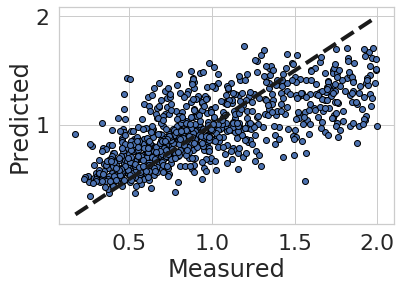

In [85]:
fig, ax = plt.subplots()
ax.scatter(y_train_d, predicted_train, edgecolors=(0, 0, 0))
ax.plot([y_train_d.min(), y_train_d.max()], [y_train_d.min(), y_train_d.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [86]:
xgbr_scores = cross_val_score(final_xgb_reg_loaded, X_test_d, y_test_d, scoring="neg_mean_squared_error", cv=10)
xgbr_rmse_scores = np.sqrt(-xgbr_scores)
display_scores(xgbr_rmse_scores)

Scores: [0.34104474 0.41570941 0.42739006 0.43723806 0.34072072 0.28998508
 0.45639851 0.29338212 0.32384898 0.32554179]
Mean: 0.36512594675391696
Standard deviation: 0.05933454624437351


In [87]:
predicted_test = cross_val_predict(final_xgb_reg_loaded, X_test_d, y_test_d, cv=10)

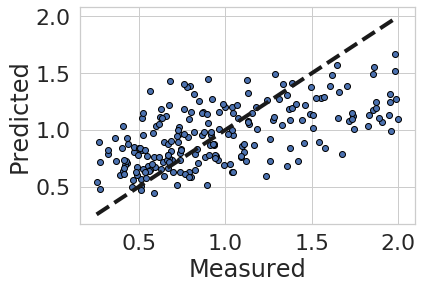

In [88]:
fig, ax = plt.subplots()
ax.scatter(y_test_d, predicted_test, edgecolors=(0, 0, 0))
ax.plot([y_test_d.min(), y_test_d.max()], [y_test_d.min(), y_test_d.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

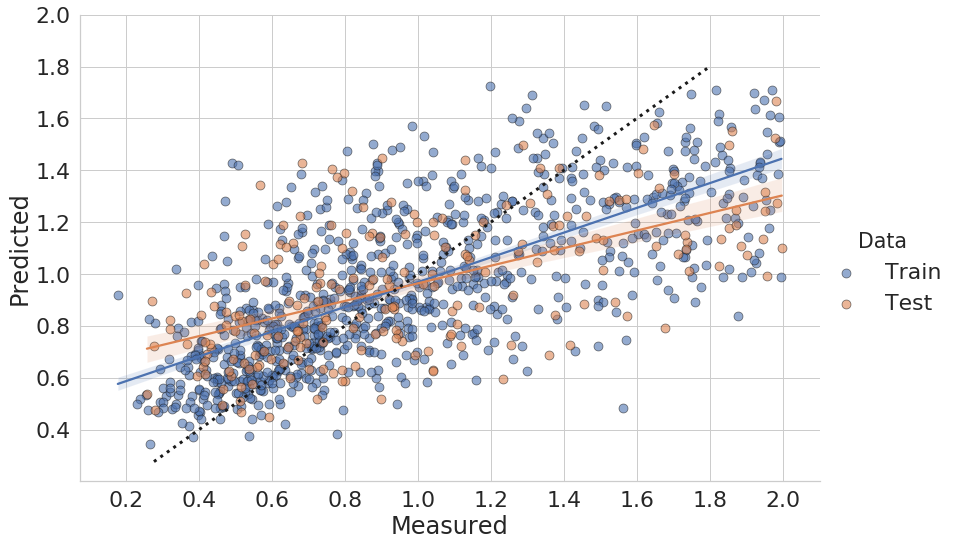

In [89]:
train_df = pd.DataFrame({'Measured':y_train_d, 'Predicted':predicted_train})
train_df['Data'] = "Train"

test_df = pd.DataFrame({'Measured':y_test_d, 'Predicted':predicted_test})
test_df['Data'] = "Test"

reg_df = pd.concat([train_df, test_df], ignore_index=True)
sns.set_style("whitegrid")
# sns.set()
# current_palette = sns.color_palette("Paired", 6)
# sns.set_palette(current_palette)

g = sns.lmplot('Measured', 'Predicted', hue='Data',
       fit_reg=True, height=8, aspect=1.5,  
       data=reg_df,
       scatter_kws={'alpha':0.6, "s": 80, 'edgecolor':'k', 'linewidth':0.75})

x0, x1 = g.ax.get_xlim()
y0, y1 = g.ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax.plot(lims, lims, ':k', lw=3)   
g.ax.set_xticks(np.arange(0.2, 2.2, step=0.2))
g.ax.set_yticks(np.arange(0.4, 2.2, step=0.2))

In [90]:
final_xgb_reg_loaded.feature_names = list(X_train_prep_d.columns)
final_xgb_reg_loaded.get_booster().feature_names = final_xgb_reg_loaded.feature_names

In [91]:
fnum = 15
booster = final_xgb_reg_loaded.get_booster()
gain = booster.get_score(importance_type="gain")
gain_top = pd.DataFrame([OrderedDict(sorted(gain.items(), key=lambda x: x[1], reverse=True)[:fnum])])
weight = booster.get_score(importance_type="weight")
weight_top = pd.DataFrame([OrderedDict(sorted(weight.items(), key=lambda x: x[1], reverse=True)[:fnum])])
cover = booster.get_score(importance_type="cover")
cover_top = pd.DataFrame([OrderedDict(sorted(cover.items(), key=lambda x: x[1], reverse=True)[:fnum])])

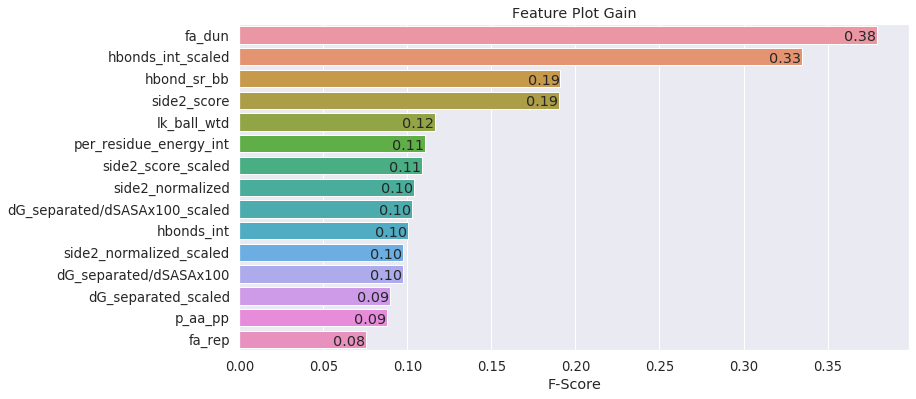

In [103]:
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Gain')
sns.barplot(data=gain_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -0.01  ,
            p.get_y()+p.get_height()/2. + 0.28,
            '{:1.2f}'.format(width),
            ha="center")

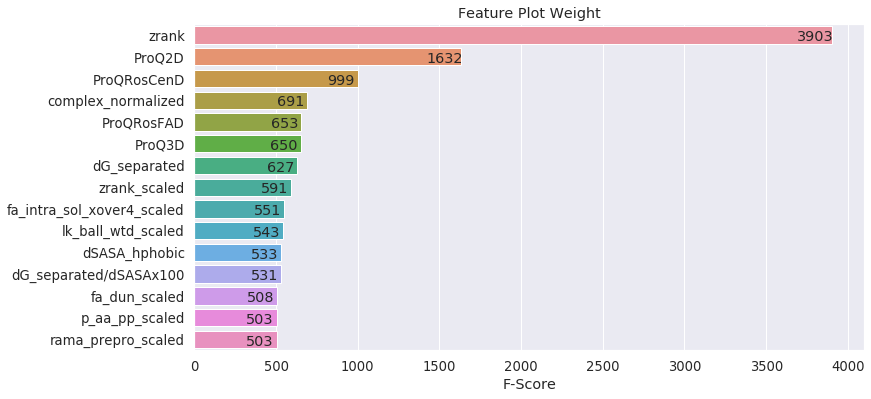

In [102]:
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Weight')
sns.barplot(data=weight_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -100.5  ,
            p.get_y()+p.get_height()/2. + 0.28,
            '{:1.0f}'.format(width),
            ha="center")